In [ ]:
pip list | grep tensorflow

tensorflow                    2.8.0
tensorflow-addons             0.16.1
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  inflating: ECGDat

In [ ]:
# !unzip /content/drive/"My Drive"/data_rr_intervals.zip

In [3]:
!pip install -q -U tensorflow_addons
!pip install neurokit2
# !pip install wfdb

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [4]:
pip install matplotlib

In [5]:
import sys
import os
%matplotlib inline
sampling_rate=500
arr_folder_location = "/content/drive/MyDrive/Arrythmia /"
sys.path.append(os.path.abspath(arr_folder_location))

In [6]:
from arryhthmia_backend import *

File Import Success


In [7]:
# !rm -rf /content/ptb-diagnostic-ecg-database-1.0.0.zip #to delete a folder

In [8]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,NN):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(NN)

    save_best_weights = ModelCheckpoint(filepath="/content/drive/My Drive/Arrythmia /weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)


### Load Data

In [9]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [10]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [11]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [12]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:55<00:00, 32.81it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1619/1779 [00:40<00:03, 43.11it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:44<00:00, 39.95it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:11<00:00, 38.34it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [13]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [14]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 498356.27it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 734991.09it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 13s 26ms/step - loss: 0.5543 - accuracy: 0.7577 - val_loss: 0.4308 - val_accuracy: 0.8399
Epoch 2/8
392/392 [==============================] - 9s 22ms/step - loss: 0.2468 - accuracy: 0.9066 - val_loss: 0.2009 - val_accuracy: 0.9210
Epoch 3/8
392/392 [==============================] - 9s 22ms/step - loss: 0.1287 - accuracy: 0.9532 - val_loss: 0.1019 - val_accuracy: 0.9609
Epoch 4/8
392/392 [==============================] - 9s 23ms/step - loss: 0.0272 - accuracy: 0.9908 - val_loss: 0.0249 - val_accuracy: 0.9914
Epoch 5/8
392/392 [==============================] - 9s 22ms/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.0721 - val_accuracy: 0.9742
Epoch 6/8
392/392 [==============================] - 9s 22ms/step - loss: 0.6463 - accuracy: 0.8989 - val_loss: 1.1048 - val_accuracy: 0.3230
Epoch 7/8
392/392 [==============================] - 9s 22ms/step - loss: 1.0996 - accuracy: 0.3351 - val_loss: 1.0998 - val_accuracy: 0.3385
Epoch

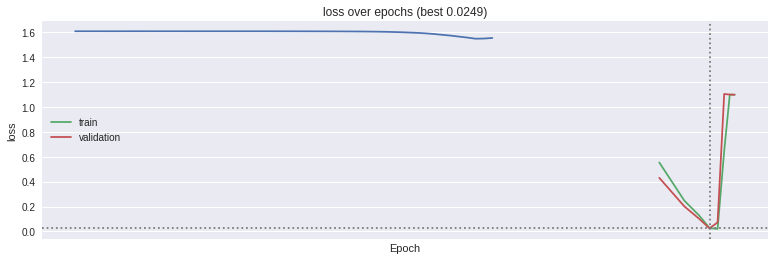

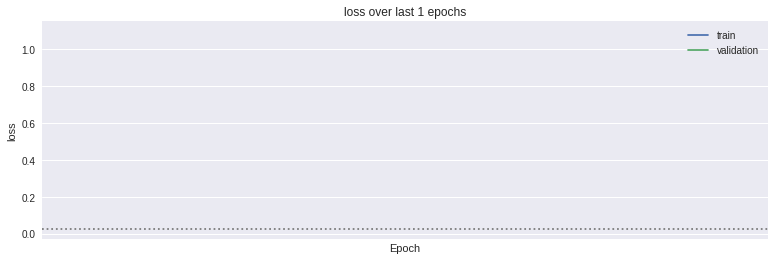

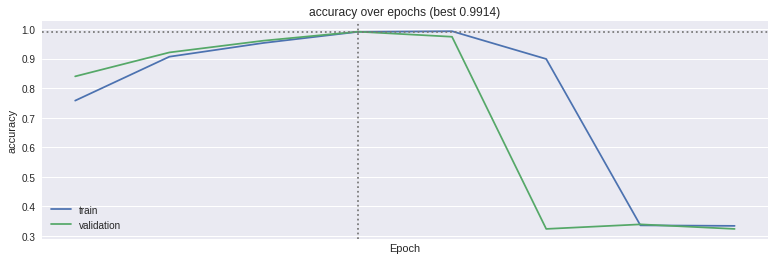

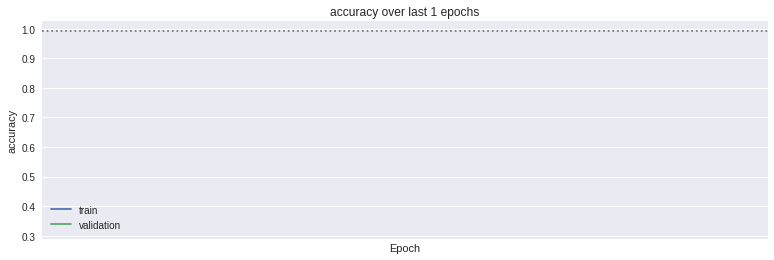


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 1s 8ms/step - loss: 0.0350 - accuracy: 0.9878
Confusion matrix, without normalization
[[920   0   4]
 [  0 904   9]
 [  5  16 927]]

****** Validation data (unseen to model) *****

184/184 [==============================] - 2s 7ms/step - loss: 0.5548 - accuracy: 0.9083
Confusion matrix, without normalization
[[1884    0   69]
 [   0 1864   89]
 [  41  338 1574]]
Final Accuracy: 90.83 %

10 fold acc: [90.83]


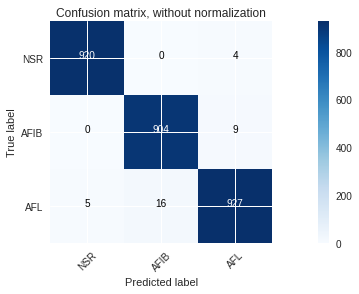

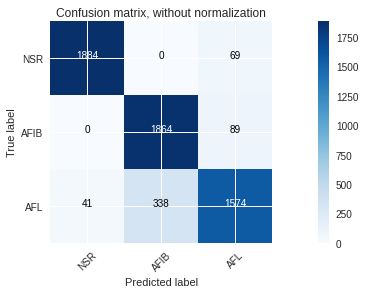

In [15]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,7)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  break
print("10 fold acc:",all_fold_acc)

In [16]:
m_resnet_model = get_resnet_model(7)

m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")

In [ ]:
import glob

path = r'/content/musecare_rr_intervals' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
name = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    one_list=df.iloc[0]
    new_df=pd.DataFrame()
    for i in range(0,len(one_list)):
      if(one_list[i]!=one_list[i+1]):
        one_list=one_list[i+1:i+101]
        one_list=one_list/1000
        one_list.reset_index(inplace=True,drop=True)
        detrended_rri = signal.detrend(one_list, axis= -1, type='constant', bp=0, overwrite_data=False).tolist()
        
        new_df=new_df.append(pd.DataFrame(detrended_rri).transpose())
        break
    li.append(new_df)
    name.append(filename)

test_data = pd.concat(li, axis=0, ignore_index=True)
test_data['filename']=name

print(test_data.shape[0] - test_data.dropna().shape[0])
#hence 81 files have null values, will drop them

test_data=test_data.dropna()
test_data.reset_index(inplace=True,drop=True)

X_ckecker=test_data.iloc[:,:-1].values
preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

test_data['predicted_class']=preds
dct= {0:'nsr', 1:'afib', 2:'afl'}
test_data=test_data.replace({"predicted_class": dct})
test_data['predicted_class'].value_counts()

In [ ]:
# test_data.to_csv("result_arr_ppg_RRi.csv",index=False)

In [ ]:
# !wget "https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip"

--2022-04-06 09:13:40--  https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790456359 (1.7G) [application/zip]
Saving to: ‘ptb-diagnostic-ecg-database-1.0.0.zip.1’

    ptb-diagnostic-   3%[                    ]  63.44M  52.7MB/s               ^C


Each csv file includes information of 15 simultaneously measured signals:12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz).
The sampling frequency of ECG is 1000Hz.

In [17]:
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!pip install wfdb
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import sys
import glob
import os
from glob import glob
PATH = "/content/physionet.org/files/ptbdb/1.0.0/"
sys.path.append(os.path.abspath(PATH))

nsr_patients =['patient104/s0306lre','patient105/s0303lre','patient116/s0302lre','patient117/s0291lre','patient117/s0292lre',
      'patient121/s0311lre','patient122/s0312lre','patient131/s0273lre','patient150/s0287lre','patient155/s0301lre',
      'patient156/s0299lre','patient165/s0322lre','patient165/s0323lre','patient166/s0275lre','patient169/s0328lre',
      'patient169/s0329lre','patient170/s0274lre','patient172/s0304lre','patient173/s0305lre','patient174/s0300lre',
      'patient174/s0324lre','patient174/s0325lre','patient180/s0374lre','patient180/s0475_re','patient180/s0476_re',
      'patient180/s0477_re','patient180/s0490_re','patient180/s0545_re','patient180/s0561_re','patient182/s0308lre',
      'patient184/s0363lre','patient185/s0336lre','patient198/s0402lre','patient198/s0415lre','patient214/s0436_re',
      'patient229/s0452_re','patient229/s0453_re','patient233/s0457_re','patient233/s0458_re','patient233/s0459_re',
      'patient233/s0482_re','patient233/s0483_re','patient234/s0460_re','patient235/s0461_re','patient236/s0462_re',
      'patient236/s0463_re','patient236/s0464_re','patient237/s0465_re','patient238/s0466_re','patient239/s0467_re',
      'patient240/s0468_re','patient241/s0469_re','patient241/s0470_re','patient242/s0471_re','patient243/s0472_re',
      'patient244/s0473_re','patient245/s0474_re','patient245/s0480_re','patient246/s0478_re','patient247/s0479_re',
      'patient248/s0481_re','patient251/s0486_re','patient251/s0503_re','patient251/s0506_re','patient252/s0487_re',
      'patient255/s0491_re','patient260/s0496_re','patient263/s0499_re','patient264/s0500_re','patient266/s0502_re',
      'patient267/s0504_re','patient276/s0526_re','patient277/s0527_re','patient279/s0531_re','patient279/s0532_re',
      'patient279/s0533_re','patient279/s0534_re','patient284/s0543_re','patient284/s0551_re','patient284/s0552_re']

Streaming output truncated to the last 5000 lines.

2022-04-13 08:37:14 (342 MB/s) - ‘physionet.org/files/ptbdb/1.0.0/patient168/s0032_re.hea’ saved [2292/2292]

--2022-04-13 08:37:14--  https://physionet.org/files/ptbdb/1.0.0/patient168/s0032_re.xyz
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 230400 (225K) [text/plain]
Saving to: ‘physionet.org/files/ptbdb/1.0.0/patient168/s0032_re.xyz’

physionet.org/files 100%[===================>] 225.00K  --.-KB/s    in 0.003s  

2022-04-13 08:37:14 (72.7 MB/s) - ‘physionet.org/files/ptbdb/1.0.0/patient168/s0032_re.xyz’ saved [230400/230400]

--2022-04-13 08:37:14--  https://physionet.org/files/ptbdb/1.0.0/patient168/s0033_re.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 921600 (900K) [application/octet-stream]
Saving to: ‘physionet.org/files/ptbdb/1.0.0/patient168/s0033_re.dat’

physionet.org/files 100%[===================>]

In [18]:
files = nsr_patients

for i in tqdm(range(0,len(files))):
	recordname=PATH+str(files[i])+'.hea'
	
	recordname_new=recordname[-23:-4] #Extracting just the filename part (will differ from database to database)
	# print(recordname_new)
	record = wfdb.rdsamp(PATH+recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=PATH+recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	
print("\nAll files done!")

100%|██████████| 80/80 [02:41<00:00,  2.02s/it]


All files done!


In [19]:
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(7)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:42<00:00,  1.90it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            45
2              26
arrhyhthmia     7
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:33<00:00,  2.37it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            45
2              27
arrhyhthmia     6
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:32<00:00,  2.48it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            45
2              27
arrhyhthmia     6
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.52it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr            44
2              27
arrhyhthmia     7
Name: predicted_class, dtype: int64 

